In [5]:
import numpy as np
import matplotlib.pyplot as plt
from fourier import fourier_transform, get_eta
%matplotlib inline
%load_ext Cython

import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [6]:
def get_eta():                                           
    f1 = 1./12;                                          
    a1 = 1.60;                                           
    f2 = 1./4;                                           
    a2 = 0.85;                                           
    f3 = 1./1.6;                                         
    a3 = 0.15;
    dt=0.0375;                                            
    T=12.                                                
    pi = np.pi                                           
    t = np.arange(0., T, dt)
    return t, a1*np.sin(2*pi*f1*t) + a2*np.sin(2*pi*f2*t) + a3*np.sin(2*pi*f3*t)

In [7]:
def fourier_transform(eta):   
    """Own DFT function"""
    N = len(eta)                                       
    n = np.arange(N/2, dtype=np.float)                                                                            
    q = np.arange(N)                                     
                                                         
    An = np.zeros(n.shape)                               
    Bn = np.zeros(n.shape)                               
                                                         
    An[0] = eta.mean()                                   
    for i in range(1, len(An)):                          
        an = eta * np.cos(2*np.pi*q*n[i]/N)              
        bn = eta * np.sin(2*np.pi*q*n[i]/N)              
        An[i] = 2./N * an.sum()                               
        Bn[i] = 2./N * bn.sum()                                                                               
    return n, np.sqrt(An**2 + Bn**2)

In [8]:
def npfft(eta):
    """Numpy's FFT"""
    N = len(eta)
    dft = np.fft.fft(eta)/(N/2)
    E = np.sqrt(dft[:N/2].real**2 + dft[:N/2].imag**2)
    return np.arange(N/2, dtype=np.float), E

## Comparison of own DFT and Numpy's FFT

As the following figure shows, that the results of the self written discrete Fourier Transform
are equivalent with Numpy's FFT algorithm.

However, the execution speed of Numpy's FFT is significantly faster.
The internal Numpy function is almost 170 times faster.

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

t, eta = get_eta()
ax1.plot(t, eta)
ax1.set_ylabel('f(x)')
ax1.set_xlabel('x')
ax1.set_title("Time series")

n, ft = fourier_transform(eta)
freq = n/t[-1]

_, fft = npfft(eta)

ax2.plot(freq, ft, label='Self written')
ax2.plot(freq, fft, '.', label='Numpy internal')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'$\epsilon$')
ax2.set_ylabel(r'$\hat{f}(\epsilon)$')
ax2.set_title("Fourier Transform")
ax2.legend()
plt.show()

The DFTs of sea surface temperature (SST) and the temperature at 200m depth
both show the tidal peak at a period of approximatley 24h.
The lacking values are subsituted by the mean temperature of the whole time series.

The SST DFT shows a second 12h peak, which is due to the sun passing the equator twice.
In depths of 200m this does not have any effect anymore.

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:15: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  from ipykernel import kernelapp as app
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:17: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


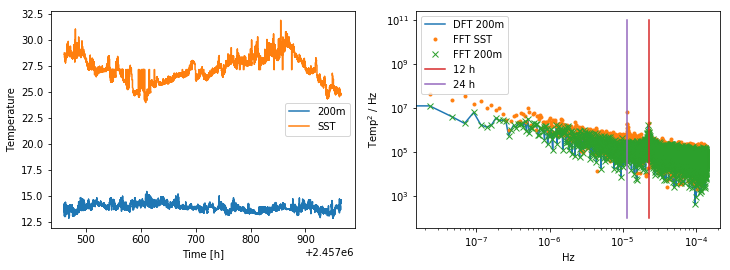

In [9]:
from netCDF4 import Dataset

with Dataset('t0n23w_hr_2byte.cdf') as df:
    time = df['time'][:]
    T_20 = df.variables["temp"][:]
    depth = df.variables["depth"][:]
    
i = -3
temp = T_20[:, i, 0, 0]
sst = T_20[:, 0, 0, 0]
N = len(temp)
df = 1./(N*60.*60.)

mask = temp.mask
temp[mask] = temp[~mask].mean()
mask = sst.mask
sst[mask] = sst[~mask].mean()

n, dft200 = fourier_transform(temp)
n, fft200 = npfft(temp)
_, dftsst = npfft(sst)
freq = n/((time[-1] - time[0])*24*60.*60.)

f24 = 1./(24*60*60)
f12 = 1./(12*60*60)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(time, temp, label='200m')
ax1.plot(time, sst, label='SST')
ax1.set_xlabel('Time [h]')
ax1.set_ylabel('Temperature')
ax1.legend()

ax2.plot(freq, dft200/df, label='DFT 200m')
ax2.plot(freq, dftsst/df, '.', label='FFT SST')
ax2.plot(freq, fft200/df, 'x', label='FFT 200m')
ax2.plot([f12, f12], [1e2, 1e11], label='12 h')
ax2.plot([f24, f24], [1e2, 1e11], label='24 h')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylabel(r'Temp$^2$ / Hz')
ax2.set_xlabel('Hz')
ax2.legend()
plt.show()

## Splitting Time series in four parts

The split of the time series in four parts of the same length
still resolves the 24h peak, but leads to an increased noise,
as can be seen from comparing it with the original data.

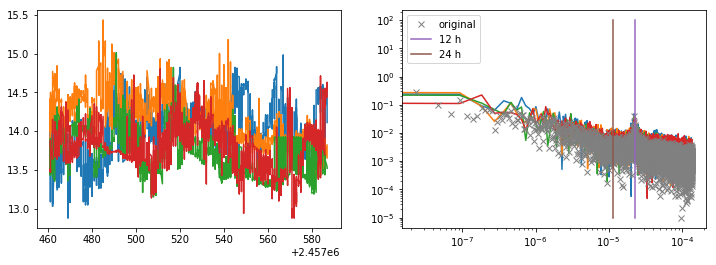

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
for t in np.split(temp[1:], 4):
    time_split = time[:len(t)]
    ax1.plot(time_split, t)
    
    n, fft_split = npfft(t)
    freq_split = n/((time_split[-1] - time_split[0])*24*60.*60.)
    ax2.plot(freq_split, fft_split)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
f12 = 1./(12*60*60.)
f24 = 1./(24*60*60.)
f48 = 1./(48*60*60.)
fN = 1./(60*60.)/2.

ax2.plot(freq, fft200, 'x', label='original', color='grey')
ax2.plot([f12, f12], [1e-5, 1e2], label='12 h')
ax2.plot([f24, f24], [1e-5, 1e2], label='24 h')
ax2.legend()
plt.show()

## 40 Day Sine Wave

Adding a sine wave with a period of 40 days becomes notable with the bare eye beyond an
amplitude of the wave of 0.5 $^\circ$C.
If a comparison with the original sepctrum is taken into account, it is visible even ealier

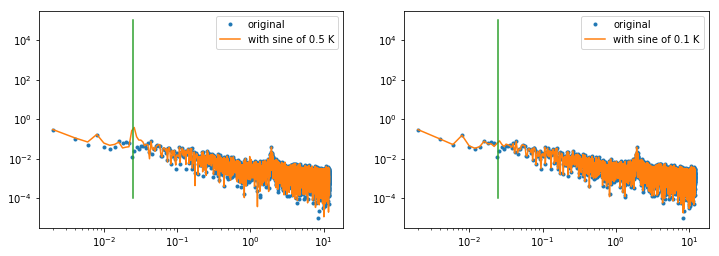

In [17]:
f = 1./(40.)
a = 5e-1
temp40 = temp + a * np.sin(2*np.pi*f*time)

n, fft40 = npfft(temp40)
n, fft = npfft(temp)
freq = n/(float(time[-1]-time[0]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(freq, fft, '.', label='original')
ax1.plot(freq, fft40, label='with sine of '+str(a)+' K')
ax1.plot([f, f], [10e-5, 10e4])
ax1.loglog()
ax1.legend()


a = 1e-1
temp40 = temp + a * np.sin(2*np.pi*f*time)

n, fft40 = npfft(temp40)
n, fft = npfft(temp)
freq = n/(float(time[-1]-time[0]))

ax2.plot(freq, fft, '.', label='original')
ax2.plot(freq, fft40, label='with sine of '+str(a)+' K')
ax2.plot([f, f], [10e-5, 10e4])
ax2.loglog()
ax2.legend()
plt.show()

## Aliasing

The Nyquist freqency $f_N$ sets a limit to the largest frequency that can be
resolved by a DFT.

$$f_N = \frac{f_S}{2}$$

This means that periods that are smaller than twice the sampling period cannot be resolved.
With a measuring frequency of 1/hour, we can thus only resolve periods longer than 2 hours,
which becomes clear from the left figure below.

Once the sampling is as coarse as 2 days, it is also not possible anymore to resolve the 10 hour sine wave.

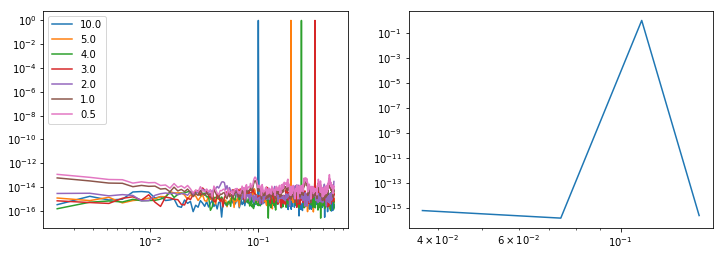

In [19]:
time = np.arange(0., 30.*24.)
freqs = 1./np.array([10., 5., 4., 3., 2., 1., .5])
fN = 1./2.

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
for f in freqs:
    y = np.sin(2*np.pi*time*f)
    n, fft = npfft(y)
    freq = n/(time[-1]-time[0])
    ax1.plot(freq, fft, label=1./f)
    ax1.loglog()
    ax1.legend()
  
f = freqs[0]
time = np.arange(0.,30.,3.)
y = np.sin(2*np.pi*time*f)
n, fft = npfft(y)
freq = n/(time[-1]-time[0])
ax2.plot(freq, fft)
ax2.loglog()
plt.show()

In [24]:
%%cython -c=-O3
import numpy as np
cimport numpy as np



cpdef fourier_transform(np.ndarray[np.float_t, ndim=1] eta):        
    cdef int N, i, j
    cdef float an, bn, pi
    cdef np.ndarray[np.float_t, ndim=1] n, An, Bn, q
    
    n = np.arange(N/2)
    pi = np.pi
    N = len(eta)                                         
    q = np.arange(N)

    An = np.zeros(N/2)                               
    Bn = np.zeros(N/2)                               

    An[0] = eta.mean()                                   
    for i in range(1, N/2): 
        for j in range(N):
            An[i] += eta[j] * np.cos(2*pi*q[j]*n[i]/N)
            Bn[i] += eta[j] * np.sin(2*pi*q[j]*n[i]/N)
        An[i] *= 2./N                              
        Bn[i] *= 2./N      
    return n, An**2 + Bn**2   